<h1 align="center">Scientific Programming in Python</h1>
<h2 align="center">Topic 4: Just in Time Compilation: Numba and NumExpr </h2> 


_Notebook created by Martín Villanueva - `martin.villanueva@usm.cl` - DI UTFSM - April 2017._

In [102]:
%matplotlib inline
%load_ext memory_profiler

import numpy as np
import numexpr as ne
import numba
import math
import random
import matplotlib.pyplot as plt
import scipy as sp
import sys

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Table of Contents
* [1.- Just in Time Compilation](#jit)
* [2.- Numba](#numba)
* [3.- Applications](#app)
* [4.- NumExp](#numexpr)


<div id='jit' />
## 1.- Just in Time Compilation

A __JIT compiler__ runs after the program has started and compiles the code (usually bytecode) __on the fly__ (or __just-in-time__, as it's called) into a form that's usually faster, typically the host __CPU's native instruction set__. A JIT has access to __dynamic runtime information__ whereas a standard compiler doesn't and can make better optimizations like inlining functions that are used frequently.

This is in contrast to a traditional compiler (__AOT__, _Ahead Of Time_ compilation) that compiles all the code to machine language __before the program is first run__.

<div id='numba' />
## 2.- Numba

* Numba takes pure Python code and translates it automatically __(just-in-time)__ into optimized machine code, thanks to the __LLVM__ (_Low Level Virtual Machine_) compiler architecture.
* We can write a non-vectorized function in pure Python, using for loops, and have this function __vectorized automatically__ by using a single decorator.
* Performance speedups when compared to pure Python code can reach several orders of magnitude and may even outmatch manually-vectorized `NumPy` code.

#### Why `NumPy` is not sufficient?
1. Sometimes it is difficult to __visualize a vectorized implementation__ of an algorithm (difficult to understand also),
2. And sometimes it is just __imposible__ to implement a vectorized solution (_Typical case:_ When we need the result from from one iteration to perform the next).

(_Some kind of_) __Rule of thumb:__ When a loop in an algorithm needs the result from one iteration to perform the next iteration, then it is not possible to implement it in a vectorized way.

Lets introduce its usage with a naive example:

### Array sum

The function below is a naive sum function that sums all the elements of a given array.

In [5]:
def sum_array(inp):
    I,J = inp.shape
    mysum = 0
    for i in range(I):
        for j in range(J):
            mysum += inp[i, j]
    return mysum

In [16]:
arr = np.random.random((500,500))

In [17]:
sum_array(arr)

125116.56975142167

In [24]:
naive = %timeit -o sum_array(arr)

10 loops, best of 3: 67.9 ms per loop


In [25]:
#lazzy compilation
@numba.jit
def sum_array_numba(inp):
    I,J = inp.shape
    mysum = 0
    for i in range(I):
        for j in range(J):
            mysum += inp[i, j]
    return mysum

In [26]:
sum_array_numba(arr)

125116.56975142167

In [27]:
jitted = %timeit -o sum_array_numba(arr)

1000 loops, best of 3: 290 µs per loop


In [40]:
print("Improvement: {0} times faster".format(naive.best/jitted.best))

Improvement: 233.70029383189208 times faster


In [15]:
%timeit np.sum(arr)

The slowest run took 8.45 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 124 µs per loop


__Some important notes:__ 
* The first time we invoke a JITted function, it is translated to native __machine code__.
* The very first time you run a numba compiled function, there will be a __little bit of overhead__ for the compilation step to take place.
* As an optimizing compiler, Numba needs to __decide on the type of each variable__ to generate efficient machine code.
* When no argument are passed to the `numba.jit` decorator, this will try to __automatically detect the types of input, output and intermediate variables__.
* Additionally we can __explicitily pass the signature__ of the function to the decorator, to make the work easier for Numba :).

In [82]:
#single signature
@numba.jit('float64[:] (float64[:], float64[:])')
def sum1(a,b):
    return a+b

a = np.arange(10, dtype=np.float64)
b = np.arange(10, dtype=np.float64)
print(sum1(a,b))

[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.]


In [59]:
#multiple signatures (polymorphism)
signatures = ['int32[:] (int32[:], int32[:])', 'int64[:] (int64[:], int64[:])', \
              'float32[:] (float32[:], float32[:])', 'float64[:] (float64[:], float64[:])']
@numba.jit(signatures)
def sum2(a,b):
    return a+b

a = np.arange(10, dtype=np.int64)
b = np.arange(10, dtype=np.int64)
#print(sum1(a,b))
print(sum2(a,b))

[ 0  2  4  6  8 10 12 14 16 18]


For a full reference of the signature types supported by Numba see the [documentation](http://numba.pydata.org/numba-doc/dev/reference/types.html).

Now that we've run `sum1` and `sum2` once, they are  now compiled and we can check out what's happened behind the scenes. Use the `inspect_types` method to see __how Numba translated the functions__.

In [85]:
sum1.inspect_types()

sum1 (array(float64, 1d, A), array(float64, 1d, A))
--------------------------------------------------------------------------------
# File: <ipython-input-82-a1a79e1f67de>
# --- LINE 2 --- 
# label 0
#   del b
#   del a
#   del $0.3

@numba.jit('float64[:] (float64[:], float64[:])')

# --- LINE 3 --- 

def sum1(a,b):

    # --- LINE 4 --- 
    #   a = arg(0, name=a)  :: array(float64, 1d, A)
    #   b = arg(1, name=b)  :: array(float64, 1d, A)
    #   $0.3 = arrayexpr(expr=('+', [Var(a, <ipython-input-82-a1a79e1f67de> (4)), Var(b, <ipython-input-82-a1a79e1f67de> (4))]), ty=array(float64, 1d, C))  :: array(float64, 1d, C)
    #   $0.4 = cast(value=$0.3)  :: array(float64, 1d, A)
    #   return $0.4

    return a+b




### `nopython` mode
Numba can compile a Python function in two modes:
1. __python mode.__ In Python mode, the compiled code relies on the CPython interpreter. _(More flexible, but slow)_.
2. __nopython mode__. The code is compiled to standalone __100% machine code__ that doesn't rely on CPython, i.e, when we call the function, it doesn't pass through the CPython interpreter in any time _(Limited, but fast)_.

Citting the official documentation:
    
    Numba is aware of NumPy arrays as typed memory regions and so can speedup code using NumPy arrays. Other, less well-typed code will be translated to Python C-API calls effectively removing the "interpreter" but not removing the dynamic indirection.

__Rule of thumb:__ In order to successfully use the __nopython__ mode, we need to ensure that __no native__ and __unsupported__ _Python features_ are being used inside the fuction to be _jitted_.

In [61]:
@numba.jit('float64[:] (float64[:,:], float64[:])', nopython=True)
def dot_numba1(A,b):
    m,n = A.shape
    c = np.empty(m)
    for i in range(m):
        c[i] = np.dot(A[i],b)
    return c

In [69]:
A = np.random.random((1000,1000))
b = np.random.random(1000)

In [70]:
%timeit dot_numba1(A,b)

1000 loops, best of 3: 1.84 ms per loop


In [73]:
@numba.jit('float64[:] (float64[:,:], float64[:])', nopython=True)
def dot_numba2(A,b):
    m,n = A.shape
    c = []
    for i in range(m):
        c.append( np.dot(A[i],b) )
    return np.array(c)

# A few time ago, it wouldn't work!

In [72]:
%timeit dot_numba2(A,b)

100 loops, best of 3: 1.9 ms per loop


Lets create a silly example where Numba fails at nopython mode. Prepare for a long error...

In [74]:
@numba.jit('float64[:] (float64[:,:], float64[:])', nopython=True)
def dot_numba2(A,b):
    m,n = A.shape
    c = dict()
    for i in range(m):
        c[i] =  np.dot(A[i],b) 
    return np.array(c.values)

TypingError: Failed at nopython (nopython frontend)
Untyped global name 'dict': cannot determine Numba type of <class 'type'>
File "<ipython-input-74-e994866243f3>", line 4

for a full list of the supported native Python features see [here](http://numba.pydata.org/numba-doc/dev/reference/pysupported.html). 

### `Numba` and `NumPy`
* One objective of Numba is having a seamless integration with NumPy.
* Numba excels at generating code that executes on top of NumPy arrays.
* Numba understands calls to (_some, almost all_) NumPy features, and is able to generate __equivalent native code__ for many of them.

To see all the feature of `NumPy` actually supported by `Numba`, please see the [documentation](http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html).

In [79]:
#row mean example
@numba.jit('float64[:] (float64[:,:])', nopython=True)
def row_mean(A):
    m,n = A.shape
    mean = np.empty(m)
    for i in range(m):
        mean[i] = np.sum(A[i])/n
    return mean

A = np.random.random((10,10))
print( row_mean(A) )

[ 0.566947    0.60758041  0.33384039  0.46504214  0.37868757  0.50759552
  0.52168599  0.40310587  0.60395361  0.55258176]


### Ahead of time Compilation
Numba also provides a facility for Ahead-of-Time compilation (AOT), which has the following beneficts:
1. AOT compilation produces a compiled extension module which does not depend on Numba.
2. There is no compilation overhead at runtime.

But it is __much more restrictive than JIT functionality__. For more info see the [documentation](http://numba.pydata.org/numba-doc/dev/user/pycc.html).

<div id='app' />
## 3.-Applications

### Random Walks

We will simulate random walk with jums: 
1. A particle is on the real line, starting at 0. 
2. At every time step, the particle makes a step to the right or to the left.
3. If the particle crosses a threshold, it is reset at its initial position.

_This type of stochastic model is notably used in neuroscience._

We first create a function that returns a `-1` or `+1` value:

In [126]:
def step():
    if random.random()>.5: return 1.
    else: return -1.

and create the simulation in pure Python, where the function `walk()` takes a number of steps as input:

In [127]:
def walk(n):
    x = np.zeros(n)
    dx = 1./n
    for i in range(n-1):
        x_new = x[i] + dx * step()
        if abs(x_new) > 5e-3:
            x[i+1] = 0.
        else:
            x[i+1] = x_new
    return x

Now we create a random walk, plot it and `%timeit` its execution: 

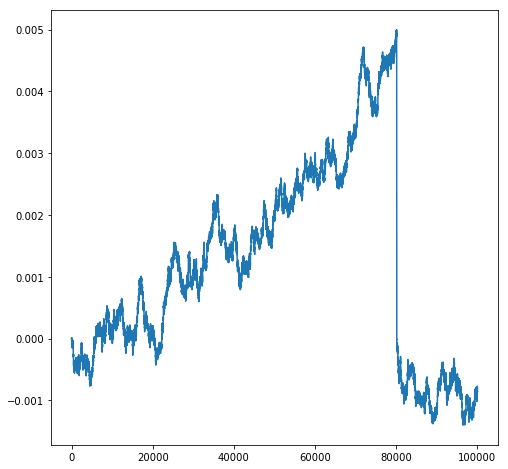

In [128]:
n = 100000
x = walk(n)

plt.figure(figsize=(8,8))
plt.plot(x)
plt.show()

In [133]:
python_t = %timeit -o walk(n)

10 loops, best of 3: 94.3 ms per loop


Now, let's JIT-compile this function with Numba:

In [131]:
@numba.jit(nopython=True)
def step_numba():
    if random.random()>.5: return 1.
    else: return -1.

@numba.jit(nopython=True)
def walk_numba(n):
    x = np.zeros(n)
    dx = 1./n
    for i in range(n-1):
        x_new = x[i] + dx * step_numba()
        if abs(x_new) > 5e-3:
            x[i+1] = 0.
        else:
            x[i+1] = x_new
    return x

In [134]:
numba_t = %timeit -o walk_numba(n)

100 loops, best of 3: 3.2 ms per loop


In [138]:
print("Improvement: {0} times faster".format(python_t.best/numba_t.best))

Improvement: 29.51397959796894 times faster


### Mandelbrot fractal

Now we will create a [Mandelbrot fractal](https://en.wikipedia.org/wiki/Mandelbrot_set) (which is a task that cannot be vectorized) using native Python and Numba... 

It basically consist in the next iteration, with starting point $z_0 = 0$:
$$ z_{i+1} = z_{i}^2 + c  $$
for which the values of the sequence remains bounded.

In [86]:
size = 200
iterations = 100

In [90]:
def mandelbrot_python(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z= 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [91]:
m = np.zeros((size,size))
mandelbrot_python(m, size, iterations)

(-0.5, 199.5, 199.5, -0.5)

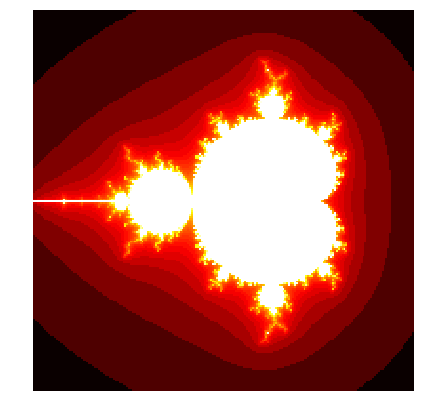

In [95]:
plt.figure(figsize=(7,7))
plt.imshow(np.log(m), cmap=plt.cm.hot)
plt.axis('off')

Now we evaluate the time taken by this function:

In [96]:
%%timeit m = np.zeros((size,size))
mandelbrot_python(m,size,iterations)

1 loop, best of 3: 2.31 s per loop


Next, we add the `numba.jit` decorator and let Numba infer the types of all the variables (_Lazzy Compilation_):

In [99]:
@numba.jit
def mandelbrot_numba(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z= 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [100]:
%%timeit m = np.zeros((size,size))
mandelbrot_python(m,size,iterations)

The slowest run took 33.82 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 6.32 ms per loop


<div id='numexpr' />
## 4.- NumExpr

### The problem...

As mention in previous lectures, `NumPy` is good (fast and efficient) at doing vector operations. Moreover, it has some problems when trying to evaluate to complex expressions: 

In [146]:
def test_func(a,b,c):
    """
    Consider that a, b and c are 1D ndarrys
    """
    return np.sin(a**2 + np.exp(b)) + np.cos(b**2 + np.exp(c)) + np.tan(a**2+b**2+c**2)

In [166]:
n = 1000000
a = np.random.random(n)
b = np.random.random(n)
c = np.random.random(n)

In [167]:
%timeit test_func(a,b,c)

10 loops, best of 3: 115 ms per loop


Let's create now a Numba function that performs the same operations but iteratively:

In [168]:
@numba.jit('float64[:] (float64[:], float64[:], float64[:])', nopython=True)
def test_func_numba(a,b,c):
    n = len(a)
    res = np.empty(n)
    for i in range(n):
        res[i] = np.sin(a[i]**2 + np.exp(b[i])) + np.cos(b[i]**2 + np.exp(c[i])) + np.tan(a[i]**2+b[i]**2+c[i]**2)
    return res

In [169]:
%timeit test_func_numba(a,b,c)

10 loops, best of 3: 81.5 ms per loop


Then, what is the problem with NumPy:
1. Implicit copy operations.
2. A lot of iterations for over the same arrays.
3. Bad usage of CPU registers...

### The solution: `NumExpr`

* Numexpr is a __fast numerical expression evaluator__ that use less memory than doing the same calculation.
* With its multi-threaded capabilities can make use of all your cores.
* It make use of __Intel's VML__ (Vector Math Library, normally integrated in its __Math Kernel Library__, or MKL).
* It follows (more or less) the JIT paradigm: Numexpr parses expressions into its own op-codes that are then used by an __integrated computing virtual machine__.
* Numexpr works best with large arrays.


### Why it is faster than `NumPy`?
1.  It avoids allocating memory for intermediate results, with better cache utilization and reduced memory access in general.
2.  The array operands are split __into small chunks__ that easily __fit in the cache of the CPU__.


Suppose we want to perform the next operation: `2*a+3*b`. In NumPy you will need 3 temporary arrays, and doesn't make an efficient use of the cache memory: The results of `2*a` and `3*b` won't be in cache when you do the add.

A possible solution it to iterate over `a` and `b` computing the operation element by element (__We test this above with Numba__). But here is the approach the `NumExpr` follows:

Arrays are handled as chunks (of 256 elements) at a time, using a register machine. As Python code, it looks something like this:
```python
for i in xrange(0, len(a), 256):
   r0 = a[i:i+256]
   r1 = b[i:i+256]
   multiply(r0, 2, r2)
   multiply(r1, 3, r3)
   add(r2, r3, r2)
   c[i:i+128] = r2
```

Let's use it!

In [185]:
# Change to size of the arrays to see the differences
m = 10000
n = 5000
A = np.random.random((m,n))
B = np.random.random((m,n))
C = np.random.random((m,n))

In [188]:
np_t = %timeit -o test_func(A,B,C)

1 loop, best of 3: 7.63 s per loop


In [190]:
ne_t = %timeit -o ne.evaluate('sin(a**2 + exp(b)) + cos(b**2 + exp(c)) + tan(a**2+b**2+c**2)')

100 loops, best of 3: 13.1 ms per loop


In [191]:
print("Improvement: {0} times".format(np_t.best/ne_t.best))

Improvement: 582.0401428646971 times


Additionally we can explicitly specify the number of _threads_ that `NumExpr` can use to evaluate the expression with the `set_num_threads()` function:

In [194]:
n_threads = 4
for i in range(1, n_threads+1):
    ne.set_num_threads(i)
    %timeit ne.evaluate('sin(a**2 + exp(b)) + cos(b**2 + exp(c)) + tan(a**2+b**2+c**2)')

10 loops, best of 3: 24.9 ms per loop
100 loops, best of 3: 14.5 ms per loop
100 loops, best of 3: 13.6 ms per loop
100 loops, best of 3: 13.2 ms per loop
